**Sources**:

[Software estimation machine learning article](https://uruit.com/blog/software-estimation-machine-learning/)

[Text preprocessing in NLP beginner guide](https://swatimeena989.medium.com/beginners-guide-for-preprocessing-text-data-f3156bec85ca#47f5)

In [37]:
import pandas as pd
import numpy as np

df = pd.read_csv("dataset.csv")

Let's check how many rows have null description:

In [38]:
df.isnull().sum()

issuekey         0
title            0
description    296
storypoint       0
dtype: int64

Let's remove incomplete entries

In [39]:
df = df.dropna(how='any')

Let's take a look on amount of items per each storypoint value:

In [40]:
df.storypoint.value_counts()

storypoint
1.0      401
0.5      354
2.0      261
3.0      135
0.0       73
5.0       49
8.0       18
0.1        5
13.0       4
80.0       4
101.0      3
4.0        2
21.0       1
1.5        1
666.0      1
40.0       1
Name: count, dtype: int64

Let's remove all the issues with storypoint estimation > 8. There are not to many samples with such SP estimation and it can only impact badly on ML model performance. And also all the issues with low amount of representatives (0.1, 4.0, 1.5)

In [41]:
df = df.loc[df['storypoint'] <= 8]
df = df.loc[df['storypoint'] != 0.1]
df = df.loc[df['storypoint'] != 4.0]
df = df.loc[df['storypoint'] != 1.5]
df.storypoint.value_counts()

storypoint
1.0    401
0.5    354
2.0    261
3.0    135
0.0     73
5.0     49
8.0     18
Name: count, dtype: int64

It is an **imbalanced** dataset as the number of _0.5_ and _1.0_ prevails over over categories. It could be an issue in *classification* problems. Let's **group** story points into 4 different categories to reduce the imbalanced data:

In [42]:
df.loc[(df.storypoint >= 0) & (df.storypoint <= 0.5), 'storypoint'] = 0 # extra_small
df.loc[(df.storypoint > 0.5) & (df.storypoint <= 1), 'storypoint'] = 1 # small
df.loc[(df.storypoint > 1) & (df.storypoint <= 2), 'storypoint'] = 2 # medium
df.loc[df.storypoint > 2, 'storypoint'] = 3 # large
df.storypoint.value_counts()

storypoint
0.0    427
1.0    401
2.0    261
3.0    202
Name: count, dtype: int64

The data is still **imbalanced**. There are different techniques to deal with imbalanced data: collecting new samples, generating new samples (**oversampling**), reducing amount of samples with higher frequency (**downsampling**). It will be done later

**Data cleanup phase**:

In [43]:
import nltk
from nltk.corpus import stopwords
import re
import unicodedata
import string

def remove_patterns_from_ends(word):
    pattern = r'^[^\w\s]+|[^\w\s]+$'

    # Use re.sub to remove patterns at the beginning and the end of the word
    cleaned_word = re.sub(pattern, '', word)

    return cleaned_word

def remove_word_if_pattern_met_twice(word):
    pattern = r'[^\w\s]'

    # Find all matches of the pattern in the word
    matches = re.findall(pattern, word)

    # Check if the pattern is encountered at least 2 times
    if len(matches) >= 2:
        return False
    else:
        # If not, remove patterns from both ends of the word
        # cleaned_word = re.sub(r'^[^\w\s]+|[^\w\s]+$', '', word)
        return True

def replace_punctuation_with_space_and_remove_one_letter_word(word):
    replaced_word = re.sub(r'[^\w\s]',' ', word)
    replaced_word_arr = replaced_word.split()
    without_one_letter = list(filter(lambda word: len(word) > 1, replaced_word_arr))
    return " ".join(without_one_letter)

def is_word_in_stopwords(word, stopwords):
    return word not in stopwords.words('english')

def cleanData1(text):
    lower_text = text.lower()
    
    text_words = lower_text.split()
    
    no_punctuation = list(map(remove_patterns_from_ends, text_words))
    text_words_without_punctuation_pattern_met_twice_in_the_middle_of_the_word = list(filter(remove_word_if_pattern_met_twice, no_punctuation))
    text_words_without_punctuation = list(map(replace_punctuation_with_space_and_remove_one_letter_word, text_words_without_punctuation_pattern_met_twice_in_the_middle_of_the_word))

    no_numbered_words = list(filter(lambda word: not any(char.isdigit() for char in word), text_words_without_punctuation))
    
    string_words_without_punctuation = " ".join(no_numbered_words)
    
    string_no_multiple_whitespaces = re.sub(' +', ' ', string_words_without_punctuation).strip()
    
    return string_no_multiple_whitespaces
 
def formatFastTextClassifier(label):
    return "__label__" + str(label) + " "

**Important**: data cleanup should be made on each issue estimation request + additional data cleanup made by @Andrei Zaporojan during dataset preparation.

Let's create 2 additional columns:
1. “title_desc” - concatenation of the title and description with applied *cleanData* function
2. "label_title_desc" - that contains the number of points with a specific prefix expected by FastText to recognize it as the labeled information (class)

In [44]:
df['title'] = df['title'].apply(cleanData1)
df['description'] = df['description'].apply(cleanData1)

In [45]:
# df.to_csv('dataset_after_cleanup9.csv', index=False)
df['title_desc'] = df['title'] + ' ' + df['description']
df['label_title_desc'] = df['storypoint'].apply(lambda x: formatFastTextClassifier(x)) + df['title_desc']

In [46]:
df = df.reset_index(drop=True)

**Dealing with imbalanced data - oversampling**

In [47]:
from collections import Counter
 
def SimpleOverSample(_xtrain, _ytrain):
    xtrain = list(_xtrain)
    ytrain = list(_ytrain)
 
    samples_counter = Counter(ytrain)
    max_samples = sorted(samples_counter.values(), reverse=True)[0]
    for sc in samples_counter:
        init_samples = samples_counter[sc]
        samples_to_add = max_samples - init_samples
        if samples_to_add > 0:
            #collect indices to oversample for the current class
            index = list()
            for i in range(len(ytrain)):
                if(ytrain[i] == sc):
                    index.append(i)
            #select samples to copy for the current class    
            copy_from = [xtrain[i] for i in index]
            index_copy = 0
            for i in range(samples_to_add):
                xtrain.append(copy_from[index_copy % len(copy_from)])
                ytrain.append(sc)
                index_copy += 1
    return xtrain, ytrain

**Creating out classifier**

A text classifier is a machine learning model that's been trained to recognize patterns in natural language text, like the sentiment expressed by a sentence.

For that purpose *FastText* classifier was used.

In [48]:
import uuid
import subprocess
import os

class FastTextClassifier:
 
    rand = ""
    inputFileName = ""
    outputFileName = ""
    testFileName = ""
    outputDir = ""
    
    def __init__(self):
        self.rand = str(uuid.uuid4())
        self.inputFileName = "issues_train_" + self.rand + ".txt"
        self.outputFileName = "supervised_classifier_model_" + self.rand
        self.testFileName = "issues_test_" + self.rand + ".txt"
        directory_path = "results/" + self.rand
        os.makedirs(directory_path, exist_ok=True)
        self.outputDir = directory_path

    def getOutputDir(self):
        return self.outputDir
    
    def fit(self, xtrain, ytrain):
        outfile=open(os.path.join(self.outputDir, self.inputFileName), mode="w", encoding="utf-8")
        for i in range(len(xtrain)):
            #line = "__label__" + str(ytrain[i]) + " " + xtrain[i]
            line = xtrain[i]
            outfile.write(line + '\n')
        outfile.close()            
        # p1 = subprocess.Popen(["cmd", "/C", "fasttext supervised -input " + self.inputFileName + " -output " + self.outputFileName + " -epoch 500 -wordNgrams 4 -dim 300 -minn 4 -maxn 6 -pretrainedVectors pretrain_model.vec"],stdout=subprocess.PIPE)
        # p1.communicate()[0].decode("utf-8").split("\r\n")
        command = [
            "fastText/fasttext",
            "supervised",
            "-input", os.path.join(self.outputDir, self.inputFileName),
            "-output", os.path.join(self.outputDir, self.outputFileName),
            "-epoch", "500",
            "-wordNgrams", "4",
            "-dim", "300",
            "-minn", "4",
            "-maxn", "6",
            "-pretrainedVectors", "pretrain_model.vec"
        ]
        
        # Run the command
        result = subprocess.run(command, stdout=subprocess.PIPE, text=True)
        
        # Check the result
        if result.returncode == 0:
            print("Command executed successfully.")
            print(result.stdout)
        else:
            print("Error executing the command.")
            print(result.stderr)
        
        
    def predict(self, xtest):
        #save test file
        outfile=open(os.path.join(self.outputDir, self.testFileName), mode="w", encoding="utf-8")
        for i in range(len(xtest)):
            outfile.write(xtest[i] + '\n')
        outfile.close()
        #get predictions
        command = [
            "fastText/fasttext",
            "predict",
            os.path.join(self.outputDir, self.outputFileName) + ".bin",
            os.path.join(self.outputDir, self.testFileName)
        ]
        
        # Run the command
        result = subprocess.run(command, stdout=subprocess.PIPE, text=True)
        
        # Check the result
        if result.returncode == 0:
            print("Command executed successfully.")
            result = result.stdout.splitlines()
        else:
            print("Error executing the command.")
            print(result.stderr)
            
        test_pred = [int(float(p.replace('__label__',''))) for p in result if p != '']
        return test_pred

**Deep learning**

FastText has pretrained vectors trained on English words from source like Wikipedia. Training process requires the file with these pretrained vectors. Author suggests to train pretrained vectors based on domain specific vocabulary. Model shows better results if pretrained vectors have been trained on domain specific text, despite the fact that this set is smaller

In [49]:
import pandas as pd
import numpy as np
 
pretrain_files = ['apache_pretrain.csv', 
                  'jira_pretrain.csv', 
                  'spring_pretrain.csv', 
                  'talendforge_pretrain.csv', 
                  'moodle_pretrain.csv',
                  'appcelerator_pretrain.csv',
                  'duraspace_pretrain.csv',
                  'mulesoft_pretrain.csv',
                  'lsstcorp_pretrain.csv'
                 ]
 
pretrained = None
 
for file in pretrain_files:
    df_pretrain = pd.read_csv('preprocessed-pretrained-data-with-stop-words/' + file, usecols=['issuekey', 'title', 'description'])
    if(pretrained is not None):
        pretrained = pd.concat([pretrained, df_pretrain])
    else:
        pretrained = df_pretrain
 
pretrained = pretrained.dropna(how='any')

In [746]:
pretrained['title_desc'] = pretrained['title'] + ' ' + pretrained['description']

**FastText** tool works with **sentences** saved in files so:

In [747]:
outfile=open("issues_pretrain.txt", mode="w", encoding="utf-8")
for line in pretrained.title_desc.values:
    outfile.write(line + '\n')
outfile.close()

Everything ready to run pretraining process 
```fasttext skipgram -input issues_pretrain.txt -output pretrain_model -epoch 100 -wordNgrams 4 -dim 300 -minn 4 -maxn 6 -lr 0.01```

**Attention**: this command execution takes time **1-1.5 hour** (at least such amount is shown in CLI). So in future if we are going to modify pretrained datasets, this time should be taken into account.

**Selecting training and testing set**

*k-fold cross-validation* technique is used for that. Training and test sets should contain as much representative data as possible. For small datasets this method is used

In [50]:
def rebuild_kfold_sets(folds, k, i):
    training_set = None
    testing_set = None
 
    for j in range(k):
        if(i==j):
            testing_set = folds[i]
        elif(training_set is not None):
            training_set = pd.concat([training_set, folds[j]])
        else:
            training_set = folds[j]
    
    return training_set, testing_set

**Defining evaluation criteria**

```TO DO:``` Fill info from the article

Methods to plot confusion matrix

In [51]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay  # Add this import for ConfusionMatrixDisplay
import os

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_confusion_matrix_with_accuracy(classes, y_true, y_pred, title, sum_overall_accuracy, total_predictions):
    cm = confusion_matrix(y_true, y_pred)
    print('Current Overall accuracy: ' + str(cm.diagonal().sum() / cm.sum()))
    
    if total_predictions != 0:
        print('Total Overall Accuracy: ' + str(sum_overall_accuracy / total_predictions))
    else:
        print('Total Overall Accuracy: ' + str(cm.diagonal().sum() / cm.sum()))

    # Use ConfusionMatrixDisplay to plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, values_format=".2f", ax=plt.gca())
    plt.title(title)
    plt.savefig(os.path.join(output_dir_global, "confusion_matrix.png"), bbox_inches='tight')
    plt.show()

**Main method** (k-fold cross-validation, with oversampling in training folders)

Read 0M words
Number of words:  4221
Number of labels: 4
Progress: 100.0% words/sec/thread:  117664 lr:  0.000000 avg.loss:  0.102809 ETA:   0h 0m 0s 12.5% words/sec/thread:  109288 lr:  0.087542 avg.loss:  0.648415 ETA:   0h 1m 5s 40.8% words/sec/thread:  114994 lr:  0.059185 avg.loss:  0.227411 ETA:   0h 0m41s 93.2% words/sec/thread:  117506 lr:  0.006781 avg.loss:  0.109196 ETA:   0h 0m 4s 94.4% words/sec/thread:  117541 lr:  0.005572 avg.loss:  0.108083 ETA:   0h 0m 3s


Command executed successfully.

Command executed successfully.
Current Overall accuracy: 0.4069767441860465
Total Overall Accuracy: 0.4069767441860465


/var/folders/b0/9cyvb6kx2d9btjzmzv24pf9w0000gp/T/ipykernel_5921/3324028779.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts["prediction"] = y_pred


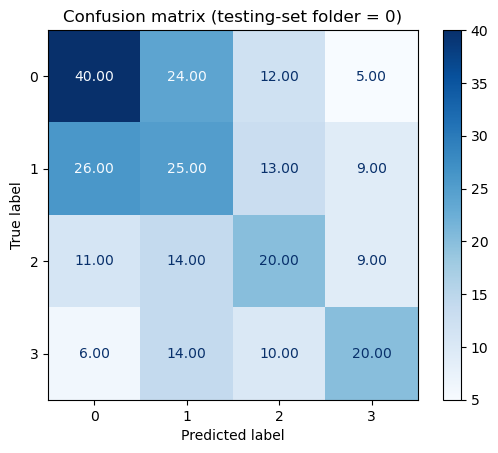

Read 0M words
Number of words:  4275
Number of labels: 4
Progress: 100.0% words/sec/thread:   88780 lr:  0.000000 avg.loss:  0.101826 ETA:   0h 0m 0s 12.2% words/sec/thread:   75730 lr:  0.087813 avg.loss:  0.654848 ETA:   0h 1m31s 25.9% words/sec/thread:   71887 lr:  0.074128 avg.loss:  0.343402 ETA:   0h 1m21s 26.7% words/sec/thread:   71319 lr:  0.073324 avg.loss:  0.335229 ETA:   0h 1m21s 43.3% words/sec/thread:   79022 lr:  0.056661 avg.loss:  0.215568 ETA:   0h 0m56s 79.4% words/sec/thread:   85292 lr:  0.020582 avg.loss:  0.124816 ETA:   0h 0m19s


Command executed successfully.

Command executed successfully.
Current Overall accuracy: 0.3992248062015504
Total Overall Accuracy: 0.40310077519379844


/var/folders/b0/9cyvb6kx2d9btjzmzv24pf9w0000gp/T/ipykernel_5921/3324028779.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts["prediction"] = y_pred


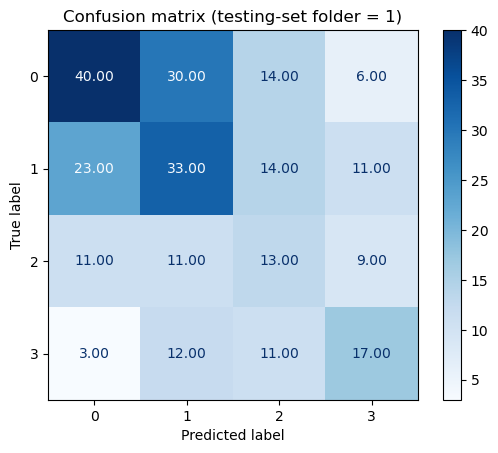

Read 0M words
Number of words:  4308
Number of labels: 4
Progress:  87.8% words/sec/thread:  104731 lr:  0.012174 avg.loss:  0.113928 ETA:   0h 0m 8s  5.7% words/sec/thread:  115562 lr:  0.094346 avg.loss:  1.074571 ETA:   0h 1m 3s 15.5% words/sec/thread:  116030 lr:  0.084527 avg.loss:  0.537693 ETA:   0h 0m56s 68.6% words/sec/thread:  105782 lr:  0.031378 avg.loss:  0.141776 ETA:   0h 0m22s

In [ ]:
from sklearn.metrics import confusion_matrix
import ipywidgets as widgets
import os
 
# K-folds cross validation 
# K=5 or K=10 are generally used. 
# Note that the overall execution time increases linearly with k
k = 5
 
# Define the classes for the classifier
classes = ['0','1','2', '3']
 
# Make Dataset random before start
df_rand = df.sample(df.storypoint.count(), random_state=99)
 
# Number of examples in each fold
fsamples =  int(df_rand.storypoint.count() / k)
 
# Fill folds (obs: last folder could contain less than fsamples datapoints)
folds = list()
for i in range(k):
    folds.append(df_rand.iloc[i * fsamples : (i + 1) * fsamples])
        
# Init
sum_overall_accuracy = 0
total_predictions = 0
 
# Repeat k times and average results
for i in range(k):
    
    #1 - Build new training and testing set for iteration i
    training_set, testing_set  = rebuild_kfold_sets(folds, k, i)
    y_true = testing_set.storypoint.tolist()
 
    #2 - Oversample (ONLY TRAINING DATA)
    X_resampled, y_resampled =  SimpleOverSample(training_set.label_title_desc.values.tolist(), training_set.storypoint.values.tolist())
    
    #3 - train
    clf = FastTextClassifier()
    output_dir_global = clf.getOutputDir()
    clf.fit(X_resampled, y_resampled)
    
    #4 - Predict
    y_pred = clf.predict(testing_set.label_title_desc.values.tolist())

    ts = testing_set[["issuekey", "title", "description", "storypoint"]]
    ts["prediction"] = y_pred
    jsonDf = ts.to_json(orient='records')
    # Save JSON data to a file
    with open(os.path.join(output_dir_global, 'backlog_items.json'), 'w') as json_file:
        json_file.write(jsonDf)

    html_content = '''<script>var backlog_items = {};</script>'''.format(jsonDf)
    html_widget = widgets.HTML(value=html_content)

    with open(os.path.join(output_dir_global, 'index.html'), 'w') as html_file:
        html_file.write(html_content)
    # widgets.HTML(value = ''' backlog_items = ''' + jsonDf)

    #3 - Update Overall Accuracy
    for num_pred in range(len(y_pred)):
        if(y_pred[num_pred] == y_true[num_pred]):
            sum_overall_accuracy += 1
        total_predictions += 1
 
    #4 - Plot Confusion Matrix and accuracy 
    plot_confusion_matrix_with_accuracy(classes, y_true, y_pred, 'Confusion matrix (testing-set folder = ' + str(i) + ')', sum_overall_accuracy, total_predictions)